# Exploratory Data Analysis
---

In [1]:
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("clean-frc-data.csv", low_memory=False)
df.head()

,index,event_code,year,description,tournamentLevel,matchNumber,matchVideoLink,actualStartTime,autoStartTime,postResultTime,...,Red3,Red3_dq,scoreBlueAuto,scoreBlueFinal,scoreBlueFoul,scoreRedAuto,scoreRedFinal,scoreRedFoul,event_date,week
0,0,VA,2006,Qualification 1,Qualification,1,NaN,NaN,NaN,NaN,...,343.0,False,0.0,12.0,0.0,0.0,49.0,0.0,2006-03-01,1
1,1,VA,2006,Qualification 2,Qualification,2,NaN,NaN,NaN,NaN,...,1236.0,False,0.0,7.0,0.0,0.0,24.0,0.0,2006-03-01,1
2,2,VA,2006,Qualification 3,Qualification,3,NaN,NaN,NaN,NaN,...,1598.0,False,0.0,20.0,0.0,0.0,21.0,0.0,2006-03-01,1
3,3,VA,2006,Qualification 4,Qualification,4,NaN,NaN,NaN,NaN,...,612.0,False,0.0,11.0,0.0,0.0,4.0,0.0,2006-03-01,1
4,4,VA,2006,Qualification 5,Qualification,5,NaN,NaN,NaN,NaN,...,346.0,False,0.0,22.0,0.0,0.0,8.0,0.0,2006-03-01,1


## Which Alliance Wins More Matches? 

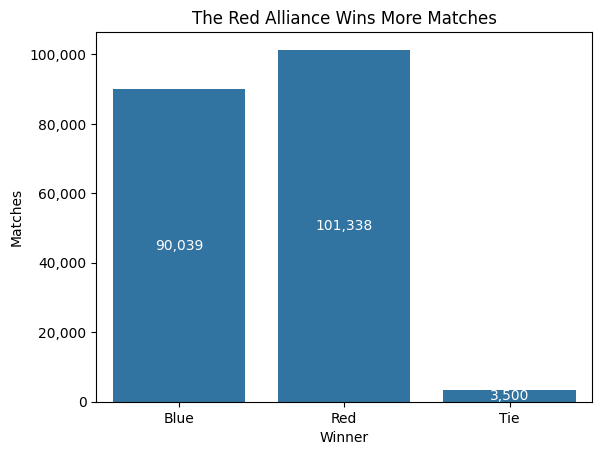

In [3]:
def who_is_the_winner(red_score, blue_score):
    """Determines which alliance should be the winner."""
    if np.isnan(red_score) or np.isnan(blue_score):
        winner = 'Error'
    elif red_score > blue_score:
        winner = 'Red'
    elif red_score < blue_score:
        winner = 'Blue'
    else:
        winner = 'Tie'
    return winner

# Determine which alliance was the winner of the match
df["Winner"] = df.apply(lambda row: who_is_the_winner(row["scoreRedFinal"], row["scoreBlueFinal"]), axis=1)
# Drop the errors from the dataset
df = df.drop(df[df.Winner == "Error"].index)
# Get the count of matches by winning alliance
viz_data = df.groupby('Winner').size().reset_index(name='Matches')
# Let's make a bar chart
graph = sns.barplot(viz_data, x='Winner', y='Matches')
# Give it a title that highlights the takeaway
graph.set_title('The Red Alliance Wins More Matches')
# Add the actual values to the chart
graph.bar_label(graph.containers[0], fmt='{:,.0f}', label_type='center', color='white')
# Add commas to the y-axis numbers
graph.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

## How Many Points Are Usually Scored in a Match?

Text(0.5, 1.0, 'Alliances Score 68 Points on Average')

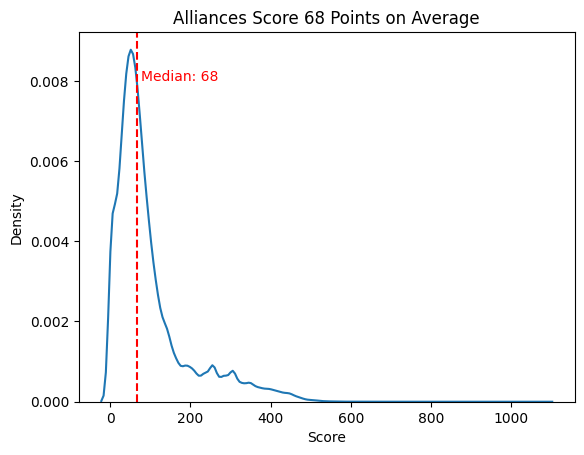

In [4]:
# Grab the final score of the red alliance and rename it to Score
viz_data = df[['scoreRedFinal']].rename({'scoreRedFinal':'Score'}, axis=1).dropna()
# Do the same thing for the blue alliance, and append it to the bottom 
viz_data = pd.concat([viz_data, df[['scoreBlueFinal']].rename({'scoreBlueFinal':'Score'}, axis=1).dropna()])
viz_data = viz_data['Score']
# Figure out what the median value is
median = int(np.median(viz_data))
# Create a distribution plot
graph = sns.kdeplot(viz_data)
# Add a red dashed line at the median
graph.axvline(median, color='r', linestyle='--')
graph.annotate(f'Median: {median}', xy=(median + 10, 0.008), xytext=(median + 10, 0.008), color='r')
# Give an informative title
graph.set_title(f'Alliances Score {median} Points on Average')

In [5]:
viz_data.describe()

count    389754.000000
mean         99.929820
std          96.356825
min           0.000000
25%          40.000000
50%          68.000000
75%         119.000000
max        1080.000000
Name: Score, dtype: float64

## What is the Distribution of the Probability of Winning?

In [6]:
# Start clean
try:
    del(match_df)
except:
    pass

# Loop over the alliance colors
for color in ["Red", "Blue"]:
    # Loop over the positions
    for num in [1, 2, 3]:
        # This the the column we want to pull
        col  = f'{color}{num}'
        # Pull the data
        temp = df[['Winner', col]].rename({col:'Team'}, axis=1).dropna()
        # Convert to integer
        temp['Team'] = temp['Team'].astype(int)
        # Add in the alliance color
        temp['Alliance'] = [color] * len(temp.index)
        # Append this temp data to our match data.  If it doesn't exist, create it.
        try:
            match_df = pd.concat([match_df, temp.copy()])
        except:
            match_df = temp.copy()

Text(0.5, 1.0, 'Most Teams Loose the Match')

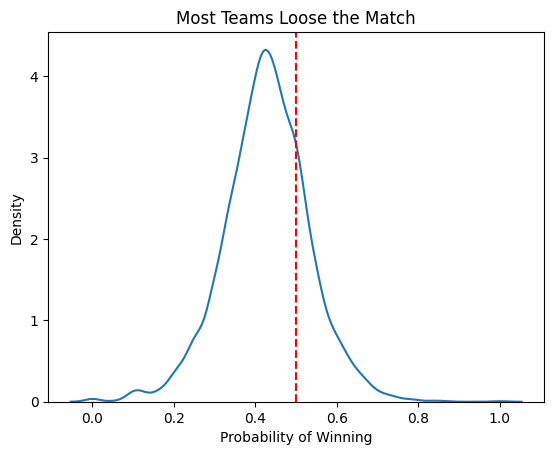

In [7]:
# Get the count of matches won by a team
viz_data = match_df[match_df.Alliance == match_df.Winner].groupby('Team').size().reset_index(name='Wins')
# Get the total number of matches by team and join the wins
viz_data = pd.merge(match_df.groupby('Team').size().reset_index(name='Matches'), viz_data, on='Team', how='left').fillna(0)
# Get the probability of winning a match
viz_data['Probability of Winning'] = viz_data['Wins'] / viz_data['Matches']
# Select the column we want to display
viz_data = viz_data['Probability of Winning']
# Create a distribution plot
graph = sns.kdeplot(viz_data)
# Add a red dashed line at the median
graph.axvline(.5, color='r', linestyle='--')
# Give an informative title
graph.set_title(f'Most Teams Loose the Match')